<a href="https://colab.research.google.com/github/Mehrnoushhk/DeepLearning/blob/master/PinAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import datetime
import mplfinance as mpl

In [2]:
import DataCleaner
from DataCleaner import dataCleaner
#from DataCleaner import localMin
#from DataCleaner import localMax
#from DataCleaner import nextHigh
#from DataCleaner import nextLow
#from DataCleaner import previousHigh
#from DataCleaner import previousLow
#from DataCleaner import nextTrend

Hello World!
Bye


In [10]:
%%time
#url= 'https://raw.githubusercontent.com/Mehrnoushhk/DeepLearning/master/GBPUSDm30.csv'
#data= pd.read_csv(url) 
data= pd.read_csv('C:\\Users\\Maryam-Goli\\Documents\\GitHub\\DeepLearning\\GBPUSDm30.csv')
data= dataCleaner(data)

Wall time: 1min 15s


In [11]:
%%time
from DataCleaner import localMin
from DataCleaner import localMax
data= localMin(data, 4)
data= localMax(data, 4)

Wall time: 18 s


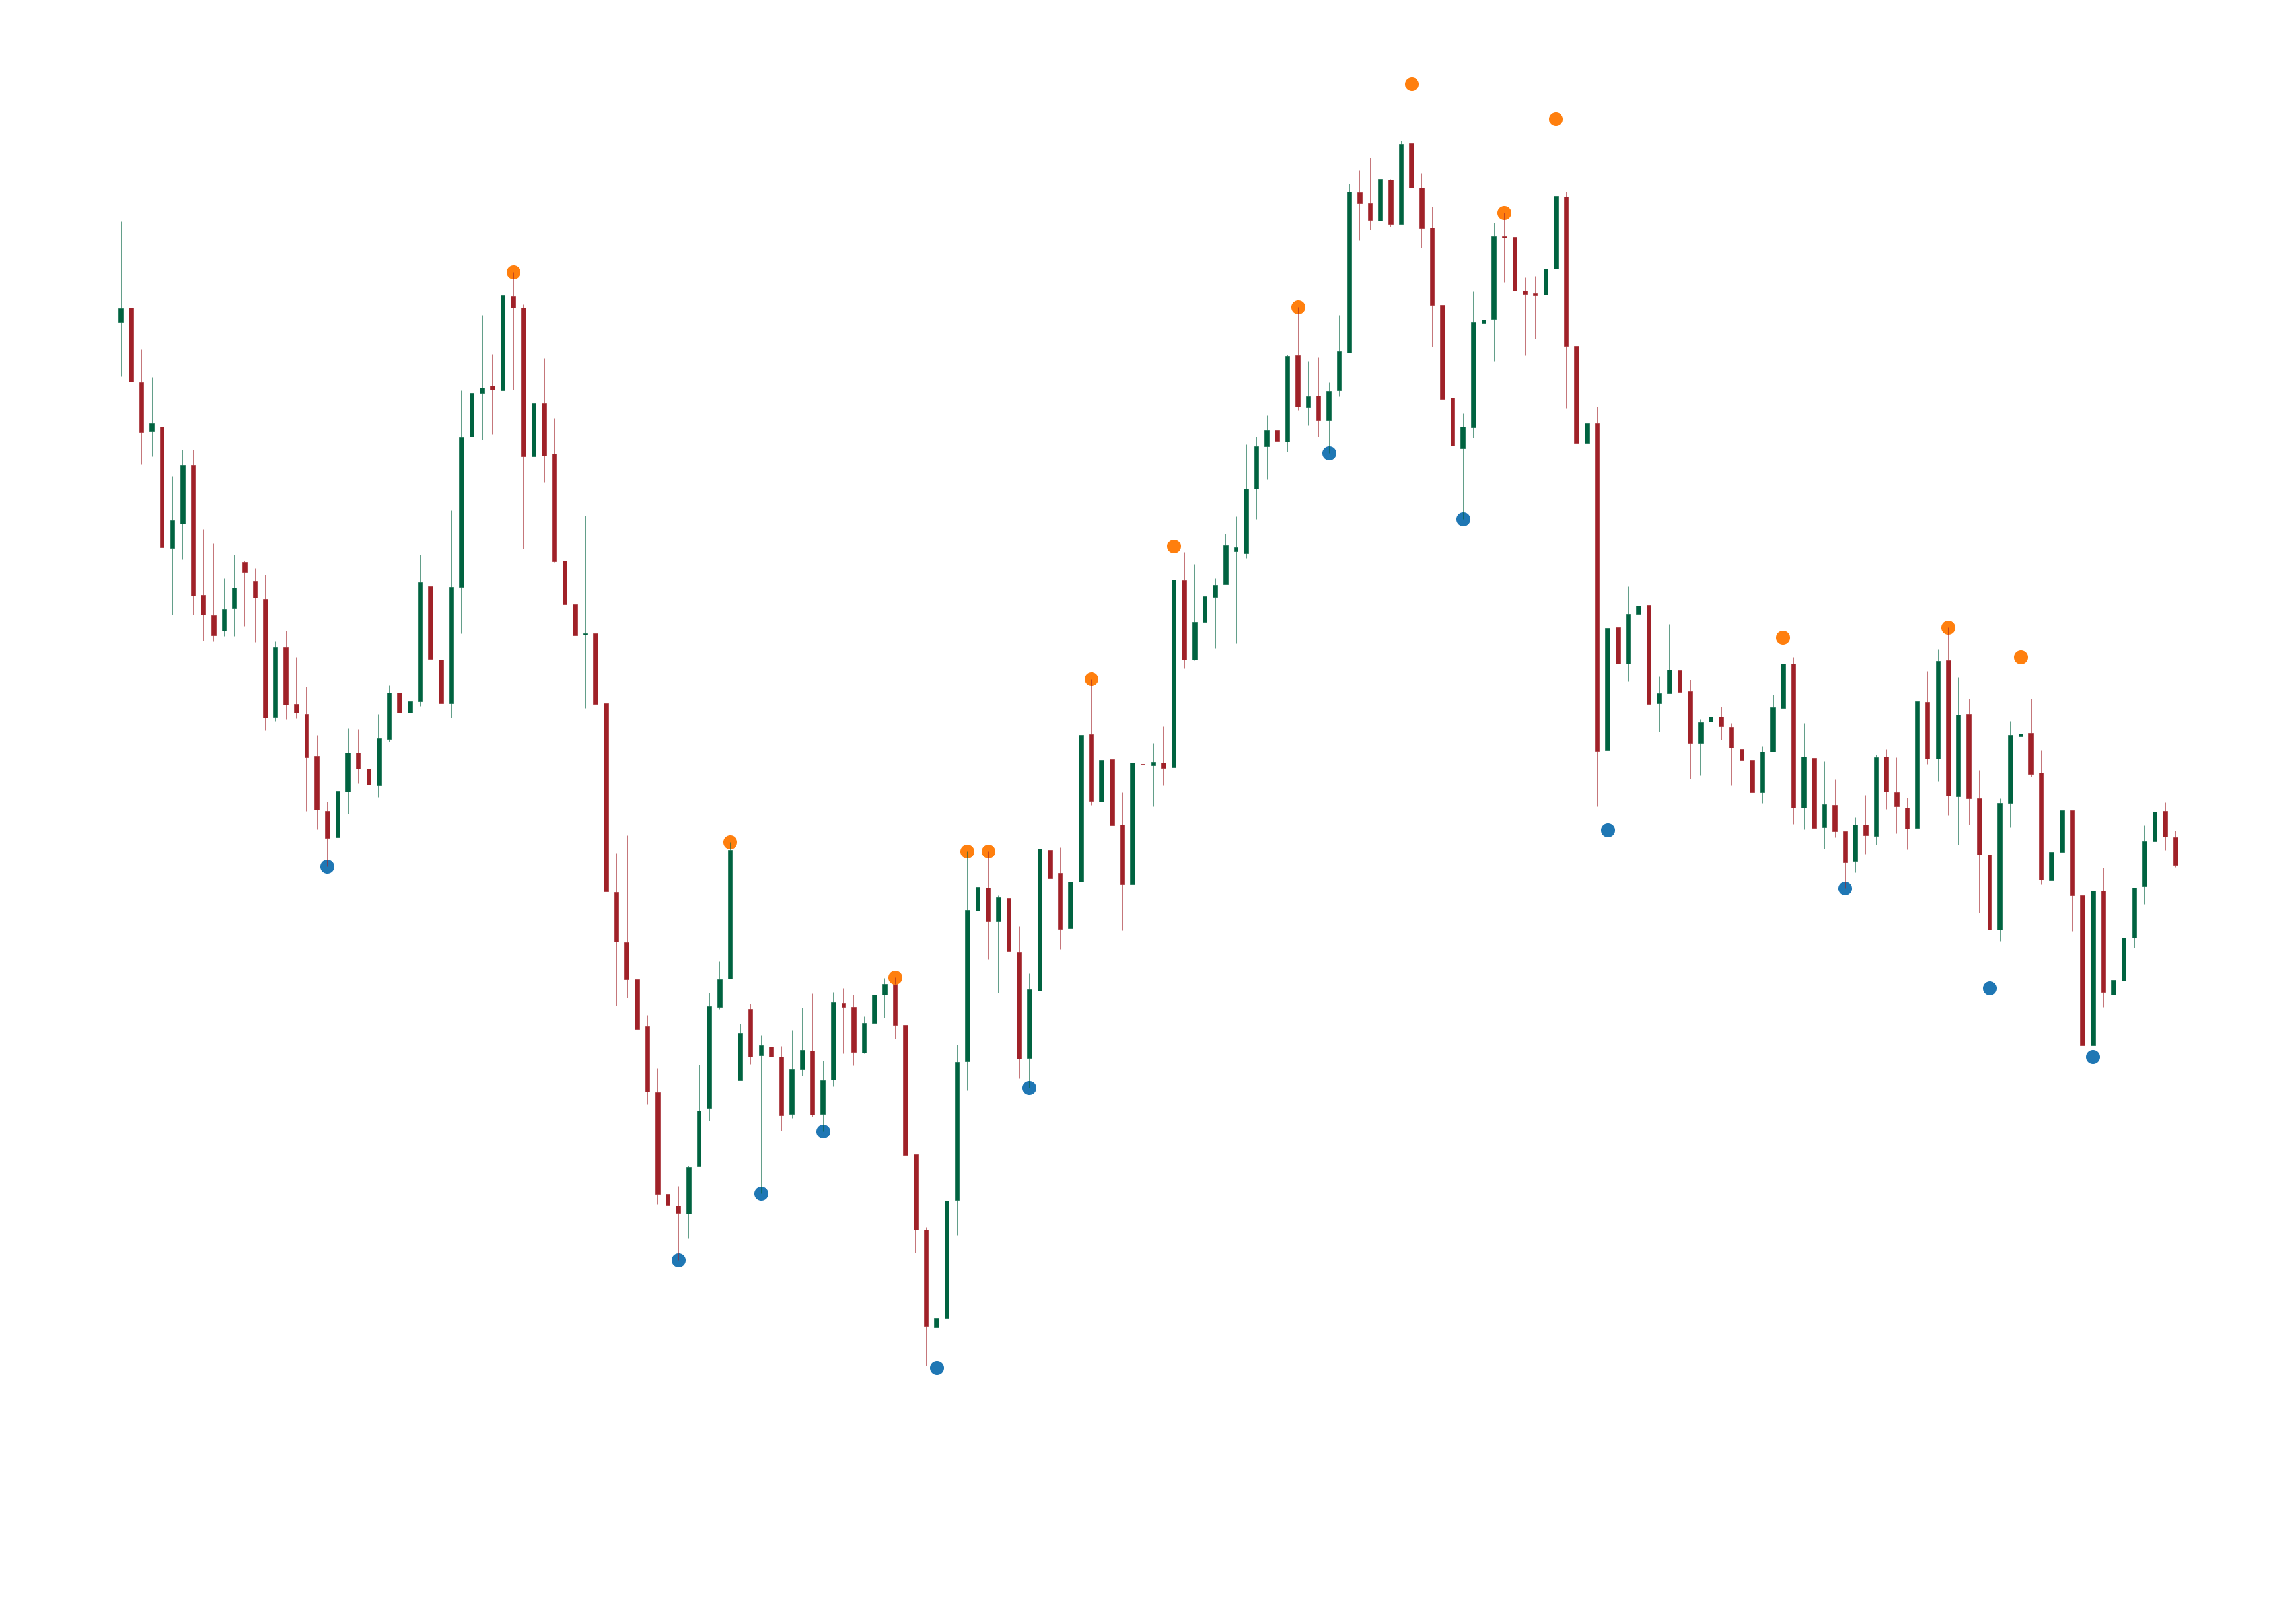

In [19]:
minMax= data[['minValue', 'maxValue']]
adp= mpl.make_addplot(minMax[len(minMax)-200:], type= 'scatter', markersize= 200)
mpl.plot(data.iloc[data.shape[0]-200: data.shape[0],:], type= 'candle', style= 'charles', figscale= 6, addplot= adp, axisoff= True)

In [13]:
columnsNames= data.columns
data = data.reindex(columns = data.columns.tolist() + ['Trend', 'TrendValue'])

In [14]:
%%time
from DataCleaner import nextTrend
data= nextTrend(data)

Wall time: 1min 16s


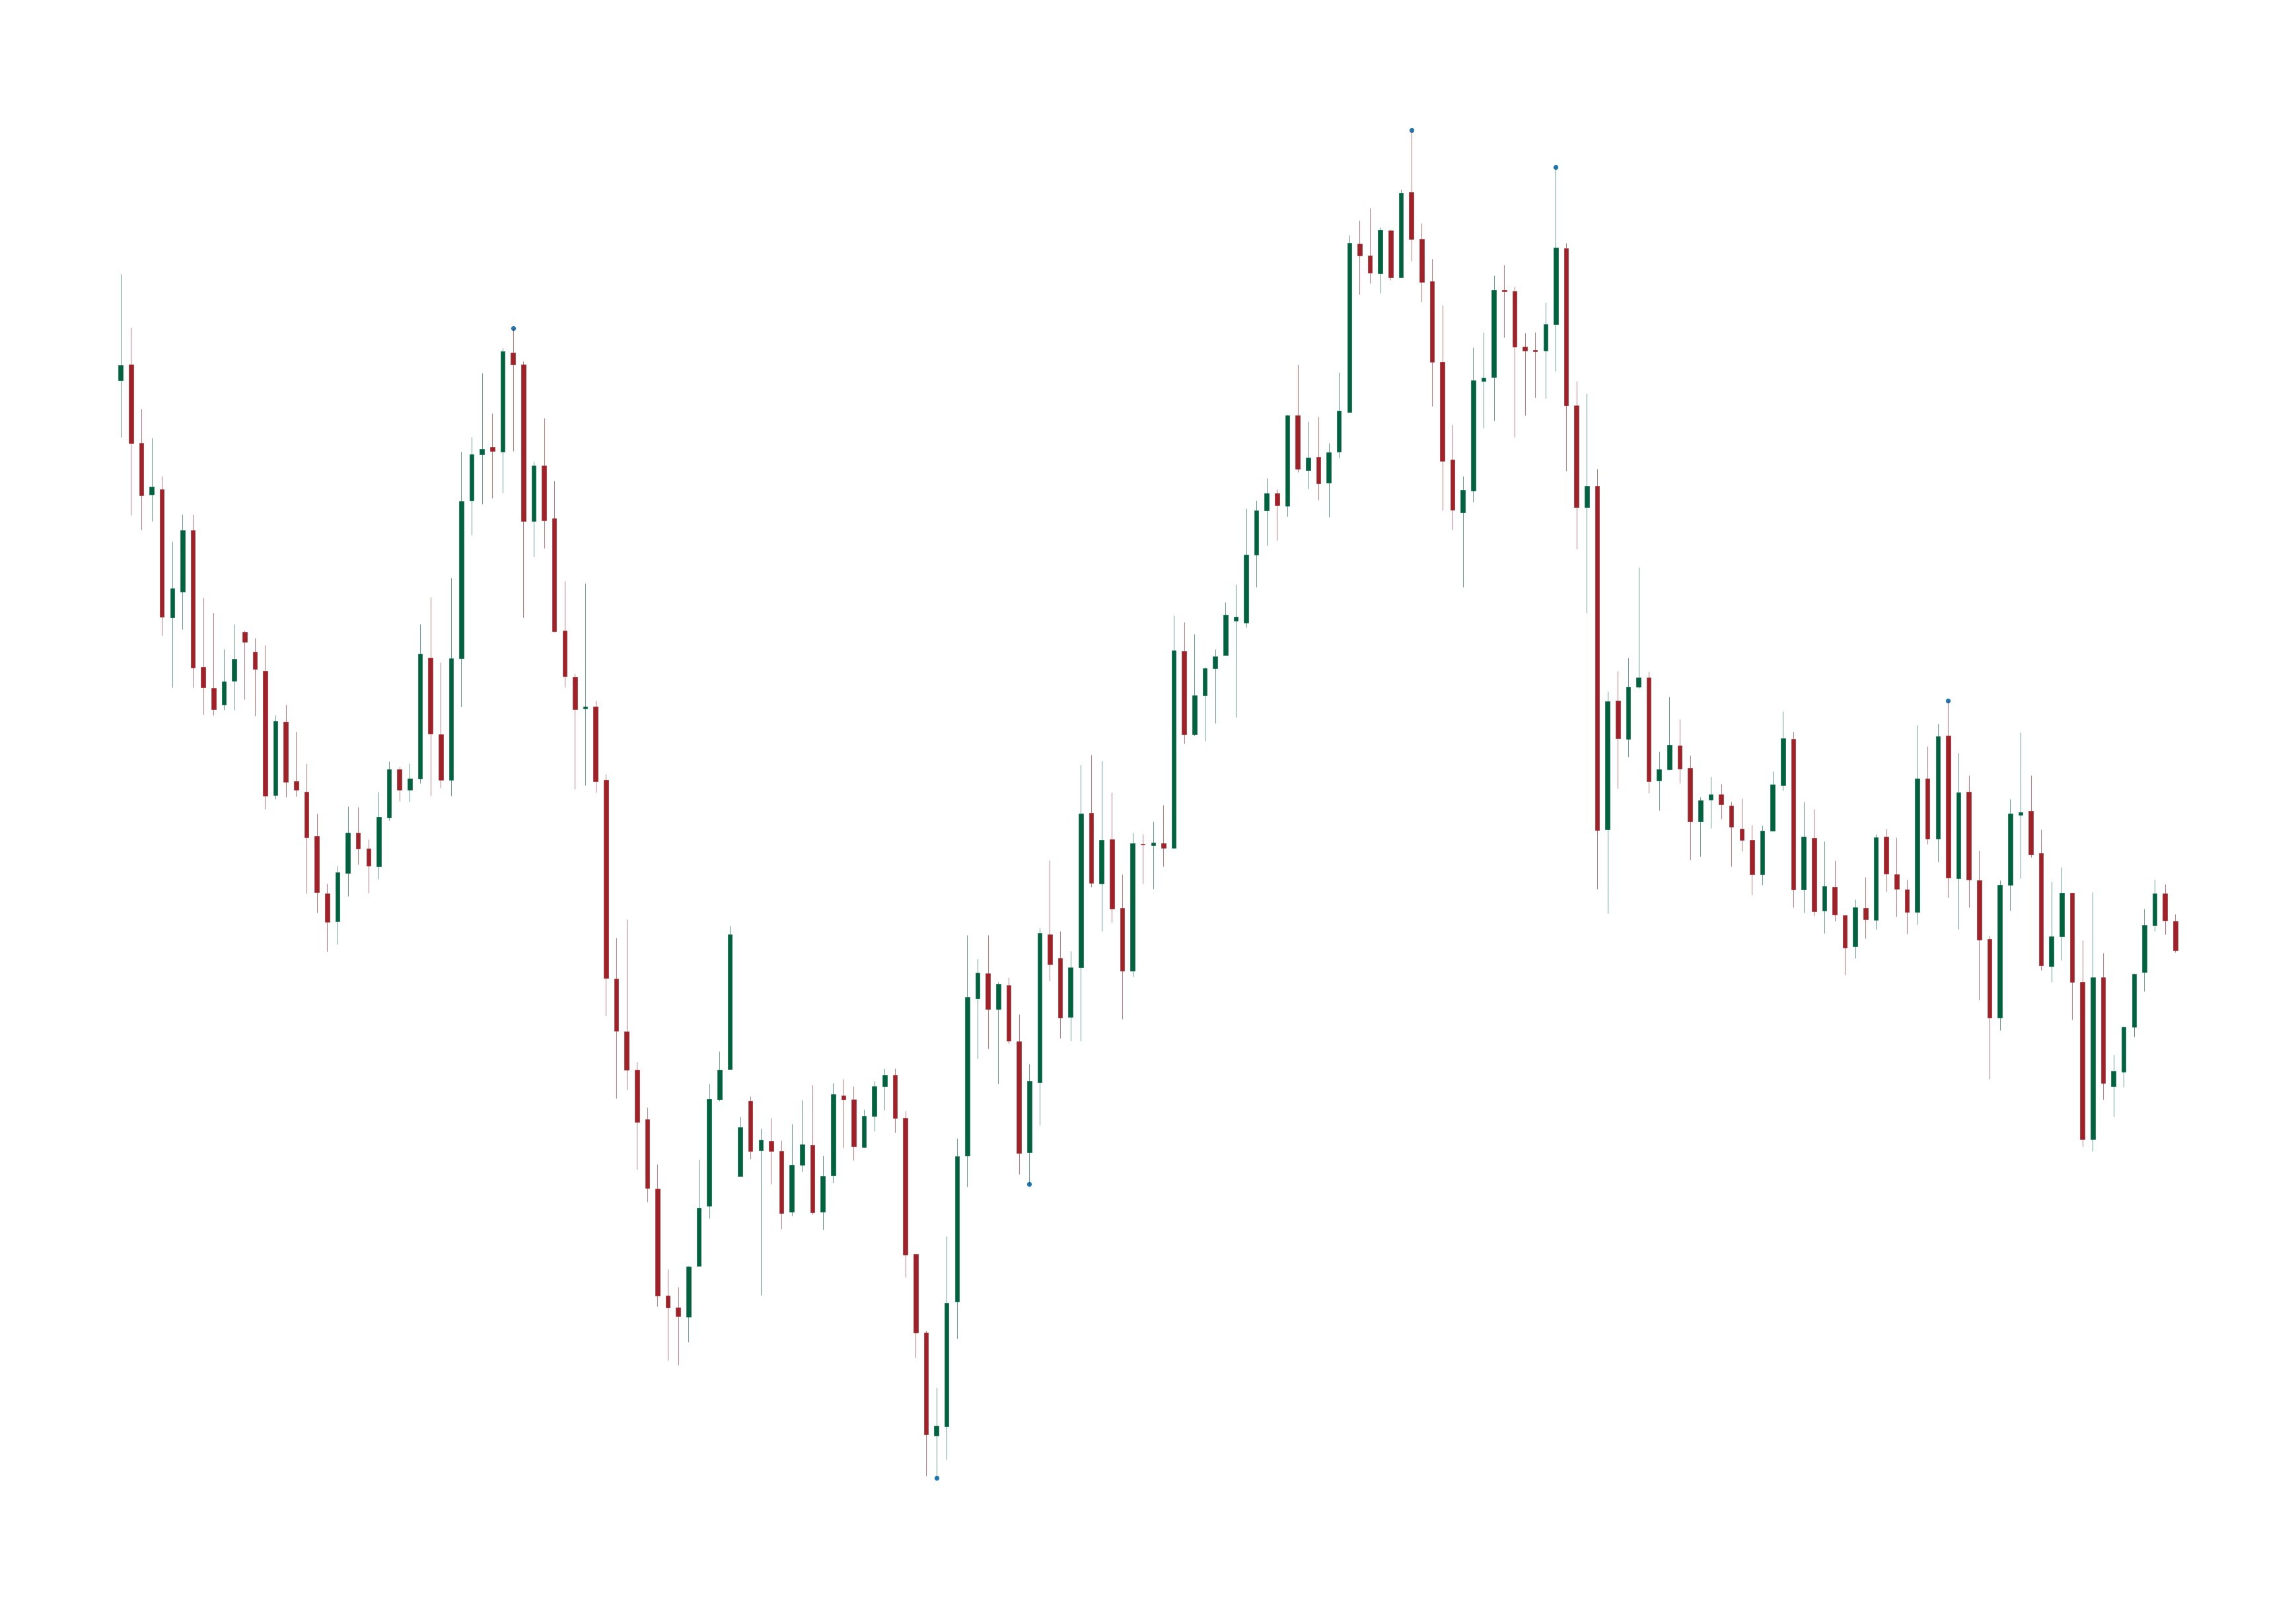

In [20]:
adp= mpl.make_addplot(data.iloc[data.shape[0]-200:, 11], type= 'scatter', markersize= 200)
mpl.plot(data.iloc[data.shape[0]-200: data.shape[0],:], type= 'candle', style= 'charles', figscale=6, addplot= adp, axisoff= True)

In [23]:
data.loc[data['Trend'] == 1].count()

Open          955
High          955
Low           955
Close         955
Volume        955
ID            955
isMin         955
minValue      955
isMax         955
maxValue       15
Trend         955
TrendValue    955
dtype: int64

In [25]:
%%time
j= data.columns.get_loc('Trend')
correction_counter= 1
uptrend_counter= 1
downtrend_counter= 1
for k in range (200, data.shape[0], 100):
    for i in range(100, k):
        if data.iloc[i,j] == 1:
            upname= 'C:\\Users\\Maryam-Goli\\Documents\\CNN\\UpTrend'+'Uptrend'+ str(uptrend_counter)+ '.png'
            mpl.plot(data.iloc[i-100:i, :], type= 'candle', style= 'charles', axisoff= True, savefig= upname)
            uptrend_counter = uptrend_counter+ 1
        elif data.iloc[i,j] == 0:
            corname= 'C:\\Users\\Maryam-Goli\\Documents\\CNN\\Consolidation'+'Consolidation'+ str(correction_counter)+ '.png'
            mpl.plot(data.iloc[i-100:i, :], type= 'candle', style= 'charles', axisoff= True, savefig= corname)
            correction_counter= correction_counter+ 1
        elif data.iloc[i, j] == -1:
            downname= 'C:\\Users\\Maryam-Goli\\Documents\\CNN\\DownTrend'+'Downtrend'+ str(downtrend_counter)+ '.png'
            mpl.plot(data.iloc[i-100:i, :], type= 'candle', style= 'charles', axisoff= True, savefig= downname)
            downtrend_counter = downtrend_counter+ 1
    input('Press any key to countinue')

MemoryError: In RendererAgg: Out of memory

In [32]:
rcparams = {'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.spines.top':False,
            'axisoff': True
            }
myStyle= mpl.make_mpf_style(base_mpf_style= 'charles', gridcolor= 'white', rc= rcparams)
mpl.plot(upTrend.iloc[0:100,:], type= 'candle', style= myStyle)

KeyError: 'axisoff is not a valid rc parameter (see rcParams.keys() for a list of valid parameters)'

In [ ]:
data['Uptrend']= np.NaN
j= data.columns.get_loc("Trend")
k= data.columns.get_loc('Uptrend')
l= data.columns.get_loc('Low')
for i in range(0, data.shape[0]):
    if data.iloc[i, j] == 1:
        data.iloc[i, k] = data.iloc[i, l]

for i in range(80, 300):
    if data.iloc[i, j] == 1:
         adp= mpl.make_addplot(data.iloc[i-80:i+10, k], type= 'scatter', markersize= 200)
         mpl.plot(data.iloc[i-80:i+10, :], type= 'candle', style= 'charles', figscale= 4, addplot= adp)

In [ ]:
counter= 1
for i in range(100, 200):
    if data.iloc[i, trendid]== 1:
        mpl.plot(data.iloc[i-100:i, :], type= 'candle', title= str(counter))
        mpl.plot(data.iloc[i: i+10,:], type= 'candle', title= str(counter))
        counter= counter+ 1

In [ ]:
pip install --upgrade mplfinance